# Incremental margin algorithm for large margin classifiers

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.datasets import load_digits
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
import warnings
warnings.filterwarnings("ignore")

## Calculating the margin

In [2]:
def compute_margin(X, y, w):
    margin = []
    X_new = np.ones((X.shape[0], X.shape[1]+1))
    X_new[:,1:] = X
    for i in range(y.shape[0]):
        margin.append((y[i]*np.dot(X_new[i,:], w))/sqrt(sum(w[1:]**2))) 
    return min(m for m in margin if m > 0)

# ELM

## ELM with IM

In [100]:
import random
from sklearn.base import BaseEstimator, ClassifierMixin
class IM_ELM(BaseEstimator, ClassifierMixin):

    # Inicialization of important parameters 
    def __init__(self, n_neurons, eta=0.01, lambda_param=0.01, delta_margin=10^-3,
                 IMA_iterations=10, max_updates=10000):
        self.n_neurons = n_neurons              # Neurons of hidden layer osf ELM
        self.eta = eta                          # Learning rate
        self.lambda_param = lambda_param        # Param important of soft margin
        self.delta_margin = delta_margin        # (1 + delta_margin) * fixed margin defines the minimum next margin of IMA
        self.IMA_iterations = IMA_iterations    # Maximum number of iterations of IMA
        self.max_updates = max_updates          # Maximum number of updates in one execution of FMP
        self.w = np.array([])                   # Vector of weights of the last layer of the ELM obtained after the training of the IMA
        self.w_elm = np.array([])               # Vector of weights of the last layer of the ELM obtained after the normal training of ELM
        self.H = np.array([])                   # H matrix of ELM (obtained with training data)
        self.Z = np.array([])                   # Z matrix of ELM

    # Fixed Margin Algorithm    
    def FMP_algorithm(self, X, y, w_init, fixed_margin):
        t = 0
        iterations = 0
        w = w_init
        norm_w = sqrt(sum(w[1:]**2))
        last_t = -1
        lambda_t = 0
        alpha = np.zeros((X.shape[0]))
        while True:
            last_t = t
            for i in range(0, y.shape[0]):
                if(y[i]*np.dot(X[i,:], w) < fixed_margin * norm_w - self.lambda_param * alpha[i]):
                    if norm_w != 0:
                        lambda_t = 1 - (self.eta*fixed_margin)/norm_w
                    else:
                        lambda_t = 1
                    alpha = alpha * lambda_t
                    alpha[i] = alpha[i] + self.eta    
                    w = w * lambda_t + self.eta * y[i] * X[i,:]
                    norm_w = sqrt(sum(w[1:]**2))
                    t += 1
            iterations += 1
            if (t > self.max_updates or last_t == t):
                break
        if t<= self.max_updates:
            convergence=1
        else:
            convergence=0
        return w, convergence, t, iterations

    # IMA Algorithm
    def IM_algorithm(self, X, y):
        self.w = self.w_elm
        fixed_margin = compute_margin(X[:,1:], y, self.w_elm)
        t = 0
        convergence = 1
        updates=0
        iterations=0
        margin=[]
        while convergence==1 and t<self.IMA_iterations:
            self.w, convergence, updates_, iterations_ = self.FMP_algorithm(X, y, self.w, fixed_margin)
            updates += updates_
            iterations += iterations_
            norm_w = sqrt(sum(self.w[1:]**2))
            gamma1 = []
            gamma2 = []
            for i in range(0, y.shape[0]):
                if y[i] == 1:
                    gamma1.append((y[i]*np.dot(X[i], self.w))/norm_w)
                else:
                    gamma2.append((y[i]*np.dot(X[i], self.w))/norm_w)
            fixed_margin = max([(min(m for m in gamma1 if m>=0) + min(m for m in gamma2 if m>=0))/2, 
                                (1+self.delta_margin)*fixed_margin])
            #margin.append(compute_margin(X, y, self.w))
            t += 1
        return t, updates, iterations, margin

    # Function that manage the training of IMA ELM
    def fit(self, X, y):
        n = X.shape[1]
        self.Z = np.array([random.uniform(-0.5, 0.5) for i in range(n*self.n_neurons)]).reshape(n, self.n_neurons)
        H = np.tanh(np.dot(X, self.Z))
        self.H = np.ones((H.shape[0], H.shape[1]+1))
        self.H[:,1:] = H
        w = np.dot(np.linalg.pinv(self.H), y)  
        self.w_elm = w.reshape((w.shape[0],))
        iterations_IMA, updates, iterations, margin = self.IM_algorithm(self.H, y) 
        return iterations_IMA, updates, iterations, margin
            
    # Function to apply IMA ELM model
    def predict(self, X, use_IMA_w=True):
        H = np.tanh(np.dot(X, self.Z))
        H_new = np.ones((H.shape[0], H.shape[1]+1))
        H_new[:,1:] = H
        if use_IMA_w == True:
            w = self.w
        else:
            w = self.w_elm
        y_predicted = np.sign(np.dot(H_new, w))
        y_predicted[y_predicted==0]=-1
        return y_predicted

## Commom ELM

In [97]:
class ELM(BaseEstimator, ClassifierMixin):
         
    def __init__(self, n_neurons):
        self.n_neurons = n_neurons
    
    def fit(self, X, y):
        # Adding polarization term 
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        n = X_new.shape[1]
        self.Z = np.array([random.uniform(-0.5, 0.5) for i in range(n*self.n_neurons)]).reshape(n, self.n_neurons)
        H = np.tanh(np.dot(X_new, self.Z))
        H_new = np.ones((H.shape[0], H.shape[1]+1))
        H_new[:,1:] = H
        self.w = np.dot(np.linalg.pinv(H_new), y)           
        return self.w, H, self.Z
            
    def predict(self, X):
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        H = np.tanh(np.dot(X_new, self.Z))
        H_new = np.ones((H.shape[0], H.shape[1]+1))
        H_new[:,1:] = H
        y_predicted = np.sign(np.dot(H_new, self.w))
        y_predicted[y_predicted==0]=1
        return y_predicted

## Aplication in the Spirals Dataset

In [5]:
def plot_decision_border(X, y, clf, use_IMA_w, fig, pos):
    ax = fig.add_subplot(pos)
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    #grid = normalizer.transform(grid)
    # make predictions for the grid
    yhat=(clf.predict(grid, use_IMA_w))
    yhat=np.array(yhat)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in [-1, 1]:
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    # show the plot
    #plt.show()  
    
def results(X, y, p):
    train_accuracy_ELM = 0
    clf = IM_ELM(n_neurons=p, eta=0.1, lambda_param=0.01, delta_margin=10^-3,
            IMA_iterations=10, max_updates=10000)
    iterations_IMA, updates, iterations_FMP, margin  = clf.fit(X, y)
    y_hat_train=clf.predict(X)
    train_accuracy_ELM = accuracy_score(y, y_hat_train)   
    margin_IM_ELM = compute_margin(clf.H[:,1:], y, clf.w)
    margin_ELM = compute_margin(clf.H[:,1:], y, clf.w_elm)

    print(f"*********** Resultado IM ELM com {p} neurônios na camada escondida **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy_ELM))
    print("Iterations: " + '{:.4f}'.format(iterations_FMP))
    print("Iterations IMA: " + '{:.4f}'.format(iterations_IMA))
    print("Updates: " + '{:.4f}'.format(updates))
    print("Margin: " + '{:.4f}'.format(margin_IM_ELM))

    print(f"*********** Resultado ELM com {p} neurônios na camada escondida **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy_ELM))
    print("Margin: " + '{:.4f}'.format(margin_ELM))

    fig = plt.figure(figsize=(11,5))
    plot_decision_border(X, y, clf, True, fig, 121)
    plot_decision_border(X, y, clf, False, fig, 122)

*********** Resultado IM ELM com 50 neurônios na camada escondida **************
Acc train: 1.0000
Iterations: 1470.0000
Iterations IMA: 10.0000
Updates: 17691.0000
Margin: 0.0003
*********** Resultado ELM com 50 neurônios na camada escondida **************
Acc train: 1.0000
Margin: 0.0000
*********** Resultado IM ELM com 40 neurônios na camada escondida **************
Acc train: 1.0000
Iterations: 1326.0000
Iterations IMA: 10.0000
Updates: 12856.0000
Margin: 0.0032
*********** Resultado ELM com 40 neurônios na camada escondida **************
Acc train: 1.0000
Margin: 0.0005
*********** Resultado IM ELM com 30 neurônios na camada escondida **************
Acc train: 1.0000
Iterations: 1800.0000
Iterations IMA: 10.0000
Updates: 19222.0000
Margin: 0.0022
*********** Resultado ELM com 30 neurônios na camada escondida **************
Acc train: 1.0000
Margin: 0.0002


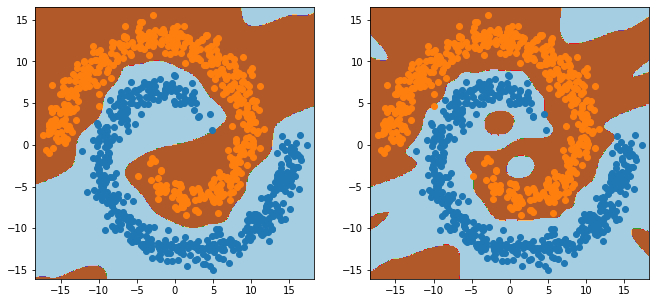

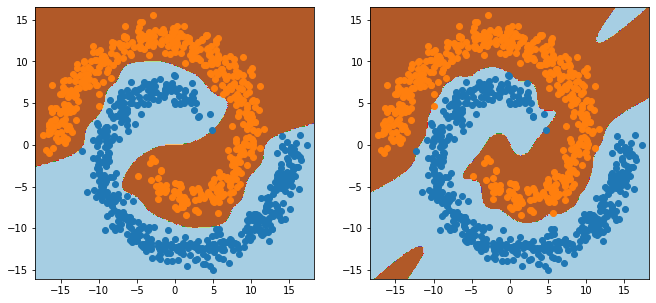

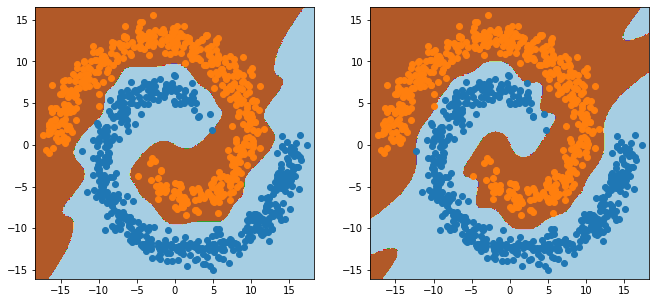

In [6]:
spirals_dataset = pd.read_csv('data/spirals/spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
y[y==2] = -1
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
for p in [50, 40, 30]:
    results(X, y, p)

## Function to capture results

In [91]:
def results3(X, y, n_splits):  
    # GridSearch for number of neurons of ELM hidden layer
    parameters = {'n_neurons':np.array(range(2*X.shape[1], 5*X.shape[1]+1))}
    clf = ELM(1)
    clf = GridSearchCV(clf, parameters, scoring='accuracy', cv=10, verbose=0)
    clf.fit(preprocessing.Normalizer().fit_transform(X), y)
    p = clf.best_params_['n_neurons']
        
    # GridSearch for lambda and learning rate of IMA ELM
    parameters = {'eta':np.linspace(0.01, 1, 6), 'lambda_param':np.linspace(0.01, 1, 6)}
    clf = IM_ELM(n_neurons=p, delta_margin=10^-3, IMA_iterations=5, max_updates=10000)
    clf = GridSearchCV(clf, parameters, scoring='accuracy', cv=10, verbose=0)
    clf.fit(preprocessing.Normalizer().fit_transform(X), y)
    eta = clf.best_params_['eta']
    lambda_param = clf.best_params_['lambda_param']
    
    # GridSearch for C parameter of SVM:
    parameters = {'C':np.array(range(1, 101))}
    clf = svm.SVC(kernel="rbf", gamma='scale')
    clf = GridSearchCV(clf, parameters, scoring='accuracy', cv=10, verbose=0)
    clf.fit(preprocessing.Normalizer().fit_transform(X), y)
    C = clf.best_params_['C']
    
    print(f'Parameters: p={p}, eta={eta}, lambda={lambda_param}, C={C}')
    # Stratified k fold cross validation
    kf = StratifiedKFold(n_splits=n_splits)
    i=0

    train_accuracy_IM_ELM = np.zeros(n_splits)
    test_accuracy_IM_ELM = np.zeros(n_splits)
    margin_IM_ELM = np.zeros(n_splits)
    updates = np.zeros(n_splits)
    iterations_FMP = np.zeros(n_splits) 
    iterations_IMA = np.zeros(n_splits)

    train_accuracy_IM_ELM_dual = np.zeros(n_splits)
    test_accuracy_IM_ELM_dual = np.zeros(n_splits)
    margin_IM_ELM_dual = np.zeros(n_splits)
    updates_dual = np.zeros(n_splits)
    iterations_FMP_dual = np.zeros(n_splits) 
    iterations_IMA_dual = np.zeros(n_splits)
    
    train_accuracy_ELM = np.zeros(n_splits)
    test_accuracy_ELM = np.zeros(n_splits)
    margin_ELM = np.zeros(n_splits)
    
    train_accuracy_SVM = np.zeros(n_splits)
    test_accuracy_SVM = np.zeros(n_splits)
    margin_SVM = np.zeros(n_splits)

    for train_index, test_index in kf.split(X, y):
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        y_train = y[train_index]
        y_test = y[test_index]

        # Normalizing data:
        normalizer = preprocessing.Normalizer()
        X_train = normalizer.fit_transform(X_train)
        X_test = normalizer.transform(X_test)
        
        # IM ELM
        clf = clf = IM_ELM(n_neurons=p, eta=eta, lambda_param=lambda_param, 
                           delta_margin=10^-3, IMA_iterations=10, max_updates=10000)
        iterations_IMA[i], updates[i], iterations_FMP[i], margin  = clf.fit(X_train, y_train)
        y_hat=clf.predict(X_test, use_IMA_w = True)
        y_hat_train=clf.predict(X_train, use_IMA_w = True)
        margin_IM_ELM[i] = compute_margin(clf.H[:,1:], y_train, clf.w)
        train_accuracy_IM_ELM[i] = accuracy_score(y_train, y_hat_train)   
        test_accuracy_IM_ELM[i] = accuracy_score(y_test, y_hat)

        # ELM
        y_hat=clf.predict(X_test, use_IMA_w = False)
        y_hat_train=clf.predict(X_train, use_IMA_w = False)
        margin_ELM[i] = compute_margin(clf.H[:,1:], y_train, clf.w_elm)
        train_accuracy_ELM[i] = accuracy_score(y_train, y_hat_train)   
        test_accuracy_ELM[i] = accuracy_score(y_test, y_hat)
              
        # SVC Classifier
        clf = svm.SVC(kernel="rbf", C=C, gamma='scale')
        clf.fit(X_train, y_train)
        y_hat=clf.predict(X_test)
        y_hat_train=clf.predict(X_train)
        train_accuracy_SVM[i] = accuracy_score(y_train, y_hat_train)   
        test_accuracy_SVM[i] = accuracy_score(y_test, y_hat)
        i+=1
        
    print("********* Results IM ELM **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy_IM_ELM.mean())+ "+/-" + '{:.4f}'.format(train_accuracy_IM_ELM.std()))
    print("Acc test: " + '{:.4f}'.format(test_accuracy_IM_ELM.mean()) + "+/-" + '{:.4f}'.format(test_accuracy_IM_ELM.std()))
    print("Iterations: " + '{:.4f}'.format(iterations_FMP.mean())+ "+/-" + '{:.4f}'.format(iterations_FMP.std()))
    print("Iterations IMA: " + '{:.4f}'.format(iterations_IMA.mean())+ "+/-" + '{:.4f}'.format(iterations_IMA.std()))
    print("Updates: " + '{:.4f}'.format(updates.mean())+ "+/-" + '{:.4f}'.format(updates.std()))
    print("Margin: " + '{:.9f}'.format(margin_IM_ELM.mean())+ "+/-" + '{:.9f}'.format(margin_IM_ELM.std()))
    
    print("********* Results ELM **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy_ELM.mean())+ "+/-" + '{:.4f}'.format(train_accuracy_ELM.std()))
    print("Acc test: " + '{:.4f}'.format(test_accuracy_ELM.mean()) + "+/-" + '{:.4f}'.format(test_accuracy_ELM.std()))
    print("Margin: " + '{:.9f}'.format(margin_ELM.mean())+ "+/-" + '{:.9f}'.format(margin_ELM.std()))

    print("********* Results SVM **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy_SVM.mean())+ "+/-" + '{:.4f}'.format(train_accuracy_SVM.std()))
    print("Acc test: " + '{:.4f}'.format(test_accuracy_SVM.mean()) + "+/-" + '{:.4f}'.format(test_accuracy_SVM.std()))
    print("Margin: " + '{:.6f}'.format(margin_SVM.mean())+ "+/-" + '{:.6f}'.format(margin_SVM.std()))
    return margin

## Application on Iris Dataset


In [92]:
iris = datasets.load_iris()
X = iris.data
# setosa - 0, versicolor - 1, virginica - 2  
y = iris.target 
# O problema agora possui apenas as classes y=-1 e y=1
y[y>0] = 1
y[y==0] = -1
results3(X, y, 10)

Parameters: p=8, eta=0.01, lambda=0.01, C=1
********* Results IM ELM **************
Acc train: 1.0000+/-0.0000
Acc test: 1.0000+/-0.0000
Iterations: 98.0000+/-36.3153
Iterations IMA: 10.0000+/-0.0000
Updates: 165.1000+/-69.0861
Margin: 0.000451841+/-0.000438108
********* Results ELM **************
Acc train: 1.0000+/-0.0000
Acc test: 1.0000+/-0.0000
Margin: 0.000397857+/-0.000357695
********* Results SVM **************
Acc train: 1.0000+/-0.0000
Acc test: 1.0000+/-0.0000
Margin: 0.000000+/-0.000000


[]

## Application on Synthetic Dataset

In [94]:
synthetic_dataset = pd.read_csv('data/synthetic_dataset/synthetic_control.data', sep="\s+",  header=None, engine='python')
X = synthetic_dataset.to_numpy()
y = np.concatenate((np.ones(100), np.ones(200)*-1, np.ones(100), np.ones(100)*-1,np.ones(100)))
results3(X, y, 10)

Parameters: p=134, eta=0.20800000000000002, lambda=0.802, C=1
********* Results IM ELM **************
Acc train: 1.0000+/-0.0000
Acc test: 0.9883+/-0.0107
Iterations: 78.7000+/-33.4576
Iterations IMA: 10.0000+/-0.0000
Updates: 160.1000+/-71.6358
Margin: 0.000643517+/-0.000345690
********* Results ELM **************
Acc train: 0.9994+/-0.0008
Acc test: 0.9900+/-0.0111
Margin: 0.000273477+/-0.000159168
********* Results SVM **************
Acc train: 1.0000+/-0.0000
Acc test: 1.0000+/-0.0000
Margin: 0.000000+/-0.000000


[]

## Application on Robot  Dataset



In [101]:
robot_dataset = pd.read_csv('data/robot/lp4_data.csv', delimiter =',')
X = robot_dataset.to_numpy().reshape([117,90])
y = np.concatenate((np.ones(24), np.ones(117-24)*-1))
results3(X, y, 10)

Parameters: p=211, eta=0.20800000000000002, lambda=0.6040000000000001, C=1
********* Results IM ELM **************
Acc train: 1.0000+/-0.0000
Acc test: 0.9742+/-0.0542
Iterations: 64.2000+/-12.8281
Iterations IMA: 10.0000+/-0.0000
Updates: 138.8000+/-31.1249
Margin: 0.233462150+/-0.027559989
********* Results ELM **************
Acc train: 1.0000+/-0.0000
Acc test: 0.8462+/-0.1386
Margin: 0.053155546+/-0.004644256
********* Results SVM **************
Acc train: 0.9915+/-0.0028
Acc test: 0.9742+/-0.0542
Margin: 0.000000+/-0.000000


[]

## Application on Ionosphere Dataset

In [102]:
ionosphere_dataset = pd.read_csv('data/Ionosphere/ionosphere.data', names=list(range(0,35)), sep=',')
y = ionosphere_dataset[34].to_numpy()
X = ionosphere_dataset.drop([34], axis='columns').to_numpy()
y[np.where(y=='g')] = 1
y[np.where(y=='b')] = -1
y = np.array(y.tolist())
results3(X, y, 10)

KeyboardInterrupt: 

## Application on Banknote Dataset

In [ ]:
# read in banknote authentication set
banknotes = pd.read_csv('data/banknote/data_banknote_authentication.txt', names=['variance', 'skewness', 'curtosis', 'entropy', 'class'], header=0)

# convert to array
X = banknotes[['variance', 'skewness', 'curtosis', 'entropy']].to_numpy()
y = banknotes[['class']].to_numpy()
y[np.where(y==0)] = -1
results3(X, y, 10)

## Application on Wine Dataset

In [ ]:
wine_dataset = pd.read_csv('data/wine/wine.data', names=['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315', 'Proline'])
# convert to array
y = wine_dataset[['Class']].to_numpy()
X = wine_dataset.drop("Class",axis='columns').to_numpy()
y[np.where(y==3)] = 1
y[np.where(y==2)] = -1
results3(X, y, 10)

## Application on WDBC Dataset

In [ ]:
wdbc_dataset = pd.read_csv('data/WDBC/wdbc.data', names=list(range(0,32)))
# convert to array
y = wdbc_dataset[1].to_numpy()
X = wdbc_dataset.drop([0, 1],axis='columns').to_numpy()
y[np.where(y=='B')] = 1
y[np.where(y=='M')] = -1
y = np.array(y.tolist())
results3(X, y, 10)

## Application on Sonar Dataset

In [ ]:
sonar_dataset = pd.read_csv('data/sonar/sonar.all-data', names=list(range(0,61)), sep=',')
y = sonar_dataset[60].to_numpy()
X = sonar_dataset.drop([60], axis='columns').to_numpy()
y[np.where(y=='R')] = 1
y[np.where(y=='M')] = -1
y = np.array(y.tolist())
results3(X, y, 10)

## Application on Bupa Dataset

In [ ]:
bupa_dataset = pd.read_csv('data/bupa/bupa.data', sep=",",  header=None, engine='python')
y = bupa_dataset[6].to_numpy()
X = bupa_dataset.drop([6], axis='columns').to_numpy()
y[np.where(y==2)] = -1
y = np.array(y.tolist())
results3(X, y, 10)

## Application on Spirals Dataset

In [ ]:
spirals_dataset = pd.read_csv('data/spirals/spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
results3(X, y, 10)